
Stochastic Processes - class 1/2024 - University of Brasília
Computational work 1 and 2 - Requantization and image analysis

Gabriel Tambara Rabelo - 241106461

References:
https://docs.opencv.org/4.x/d1/db7/tutorial_py_histogram_begins.html
https://docs.opencv.org/4.9.0/d4/d1b/tutorial_histogram_equalization.html
https://docs.opencv.org/3.4/d1/d5c/tutorial_py_kmeans_opencv.html

Para fins deste projeto, objetiva-se analisar algumas variáveis estatísticas aplicadas ao projeto anterior, de requantização e análise de imagens. Para tanto, o mesmo código base é utilizado, porém, as medidas estatísticas são processadas conforme cada imagem de distribuição normalizada é gerada. Os resultados são apresentados de acordo com a ordem de geração pelo arquivo jupyter notebook.

Percebe-se que conforme as imagens são requantizadas com resoluções menores, maior fica a distorção, ou erro, entre as médias estatísticas e as médias das PMFs calculadas.

Todas essas grandezas calculadas são obtidas conforme um certo grau de randomicidade relacionado ao conteúdo das imagens. Como tais imagens podem ter sido obtidas de diversas formas diferentes, sem uma função geradora que segue um padrão compeltamente analítico, pode-se interpretar seu conteúdo como randômico, de modo que as estatísticas obtidas de cada imagem representem variáveis aleatórias de distribuições específicas para cada conjunto de imagens que retratam a mesma coisa. Nesse contexto, essas variáveis são todas contínuas e podem assumir diversos valores, exceto pela moda, que retrata o valor do bin de maior ocorrência numa imagem, sendo, portanto, a única variável discreta, com sua faixa dinâmica dada pelos bins existentes de cada distribuição (imagem).


In [47]:
import cv2 as cv
import numpy as np
from matplotlib import pyplot as plt
from math import log2

img_size = 300
images_addr = ["folha.jpg", "torso.png", "coisa.jpg", "cerebro.jpg", "cerebro-tumor.jpg"]
images_addr.sort()
images = []

# control of when to stop showing images and progressing in the processing
def waitKey():
    cv.waitKey(0)
    cv.destroyAllWindows()

# show images
def printAll(list, subtitle):
    for i in range(len(list)):
        cv.imshow(images_addr[i] + subtitle, list[i])

# save images in the correct folder
def saveAll(list, subtitle):
    for i in range(len(list)):
        cv.imwrite("./images/" + images_addr[i][0:-4] + subtitle + images_addr[i][-4:], list[i])

def makeHist(image_list, bits):
    histList = []
    for i in range(len(image_list)):
        hist = []
        bins = np.arange(0, 257, 2 ** (8 - bits)) #257 since the bins must be 1 more than what it shows and we need even 1 more since arange excludes the last one

        if(bits <= 0 or bits > 8):
            print("bitsize out of bounds")
            exit()

        image = image_list[i].flatten()
        hist, bins_new = np.histogram(image, bins=bins)
        histList.append((hist, bins))
    return histList

def normalizeHist(histList):
    normalizedHistList = []
    for hist, bins in histList:
        total_pixels = np.sum(hist)
        normalized_hist = hist / total_pixels
        normalizedHistList.append((normalized_hist, bins))
    return normalizedHistList

def bin_centers(bin_borders):
    bin_center_list = (bin_borders[:-1] + bin_borders[1:]) / 2
    bin_center_list[-1] = 255 # it would sometimes normally go to 255.5 (since 256 is also in the bin list but is not a real value) and the max. is 255
    return bin_center_list

def expectancy(hist, bin_centers):    
    expected_val = np.sum(hist * bin_centers)
    return expected_val

def median(hist, bin_centers):
    cumulative_freq = 0
    for i, freq in enumerate(hist):
        cumulative_freq += freq
        if cumulative_freq >= 0.5:
            return bin_centers[i]

def mode(hist, bin_centers):
    max_freq_bins = np.where(hist == np.max(hist))[0]
    if len(max_freq_bins) == 1:
        return bin_centers[max_freq_bins[0]]
    else:
        return [bin_centers[i] for i in max_freq_bins]

def moment(hist, bin_centers, order, expectancy):
    moment_var = 0
    for i in range(len(hist)):  
        moment_var += ((bin_centers[i] - expectancy) ** order) * hist[i]
    return moment_var

def entropy(hist):
    var_entropy = 0
    epsilon = 10 ** (-27)
    for i in range(len(hist)):
        if hist[i] != 0:
            var_entropy += hist[i] * log2(hist[i])
        else:
            var_entropy += (hist[i] + epsilon) * log2(hist[i] + epsilon)
    return -var_entropy

def showStatisticalData(hist, bins, pre_quant_mean):
    centered_bins = bin_centers(bins)
    var_exp = expectancy(hist, centered_bins)
    var_median = median(hist, centered_bins)
    var_mode = mode(hist, centered_bins)
    var_first_centered_moment = moment(hist, centered_bins, 1, var_exp)
    var_second_moment = moment(hist, centered_bins, 2, 0)
    var_variance = moment(hist, centered_bins, 2, var_exp)
    var_third_centered_moment = moment(hist, centered_bins, 3, var_exp)
    var_third_moment = moment(hist, centered_bins, 3, 0)
    var_fourth_moment = moment(hist, centered_bins, 4, var_exp)
    var_entropy = entropy(hist)

    print("pre-quantization mean: " + str(pre_quant_mean))
    print("expectancy: " + str(var_exp))
    print("median: " + str(var_median))
    print("mode: " + str(var_mode))
    print("first_centered_moment: " + str(var_first_centered_moment))
    print("second_moment: " + str(var_second_moment))
    print("variance: " + str(var_variance))
    print("skewness: " + str(var_third_centered_moment))
    print("third_moment: " + str(var_third_moment))
    print("kurtosis: " + str(var_fourth_moment))
    print("entropy: " + str(var_entropy) + " bit(s)")

def showHist(image_list, histList, category, limit_bins=None, limit_overtext=True, statistical_data=False, pre_quant_means=None):
    for i in range(len(image_list)):
        hist = histList[i][0]
        bins = histList[i][1]

        if limit_bins is not None:
            plt.xticks(bins[::len(bins)//limit_bins], bins[::len(bins)//limit_bins])
        else:
            plt.xticks(bins)

        plt.bar(bins[:-1], hist, width=np.diff(bins), align='edge')

        if limit_overtext == False:
            for j in range(len(hist)):
                plt.text(bins[j], hist[j], str(hist[j]), ha='center', va='bottom', rotation=30)

        plt.xlabel('Bins')
        plt.ylabel('Frequency')
        plt.title('Histogram of ' + category + ' ' + images_addr[i][0:-4] + images_addr[i][-4:])
        plt.savefig("./images/hist_" + category + ' ' + images_addr[i][0:-4] + images_addr[i][-4:])
        plt.show()

        if statistical_data == True:
            showStatisticalData(hist, bins, pre_quant_means[i])

# generate bits colored resolution image data from input with kmeans
def kmeans(input, bits):
    images_formatted = []
    criteria = (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, 10, 1.0)

    for i in range(len(input)):
        images_formatted.append(np.float32(input[i]).reshape(-1, 3))
        compactness, labels, center = cv.kmeans(images_formatted[i], 2**bits, None, criteria, 10, cv.KMEANS_RANDOM_CENTERS)
        center = np.uint8(center)
        final_img = center[labels.flatten()]
        images_formatted[i] = final_img.reshape(input[i].shape)

    return images_formatted

def requantization(input, bits):
    images_formatted = []

    def normalize(x):
        return x / 255

    def denormalize(x):
        return int(255 * x)

    def quantize(x):
        return denormalize(np.round((2**bits - 1) * normalize(x)) / (2**bits - 1))

    for image in input:
        images_formatted.append(np.vectorize(quantize)(image))
    return images_formatted

def full_process(input, bits):
    # Calculate the mean before quantization
    pre_quantization_means = [np.mean(image) for image in input]

    # for better histogram representation
    # alt bits are the x axis resolution
    if bits == 1:
        alt_bits = 2
    elif bits >= 8:
        alt_bits = 16
    else:
        alt_bits = bits ** 2

    if bits >= 8:
        saveAll(input, '')
        histList = makeHist(input, bits)
        showHist(input, histList, 'grey', alt_bits, True, False)

        # normalizing result
        histList = normalizeHist(histList)
        showHist(input, histList, 'grey_normal', alt_bits, True, True, pre_quantization_means)

    else:
        # using quantization with K-MEANS to reduce colors in images to specific bits of resolution
        images_formatted = requantization(input, bits)
        saveAll(images_formatted, " in " + str(bits) + " bits")
        histList = makeHist(images_formatted, bits)
        showHist(input, histList, str(bits) + 'bts', alt_bits, False, False)

        # normalizing result
        histList = normalizeHist(histList)
        showHist(input, histList, str(bits) + 'bts_normal', alt_bits, True, True, pre_quantization_means)

    waitKey()


In [41]:
# reading and viewing images in the folder

for img in images_addr:
    images.append((cv.imread("./images/" + img)))
    ratio = img_size / images[-1].shape[1]
    images[-1] = cv.resize(images[-1], (img_size, int(images[-1].shape[0] * ratio)), cv.INTER_AREA)

saveAll(images, '')
waitKey()

In [42]:
# converting images to gray-scale format
images_bw = []
for i in range(len(images)):
    images_bw.append(cv.cvtColor(images[i], cv.COLOR_BGR2GRAY))

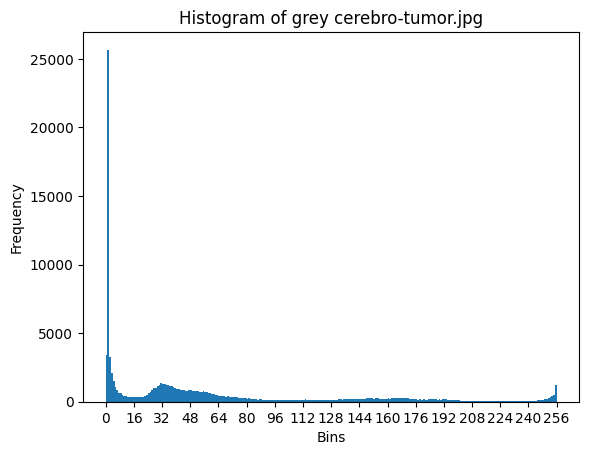

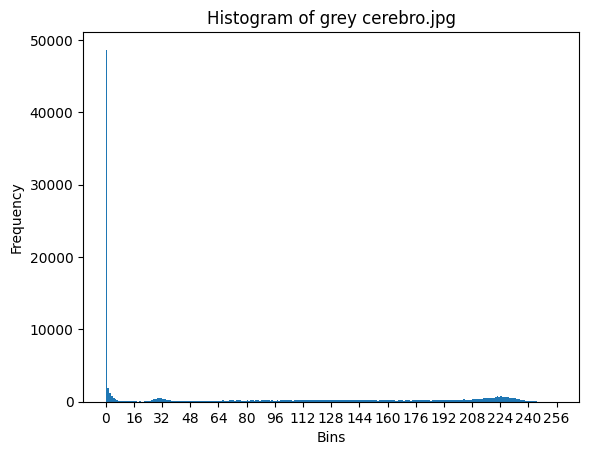

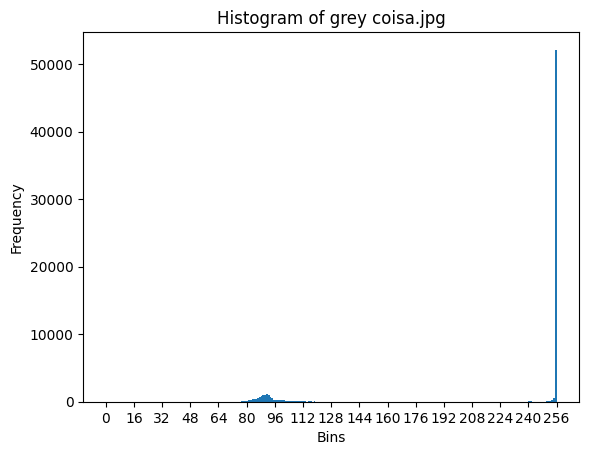

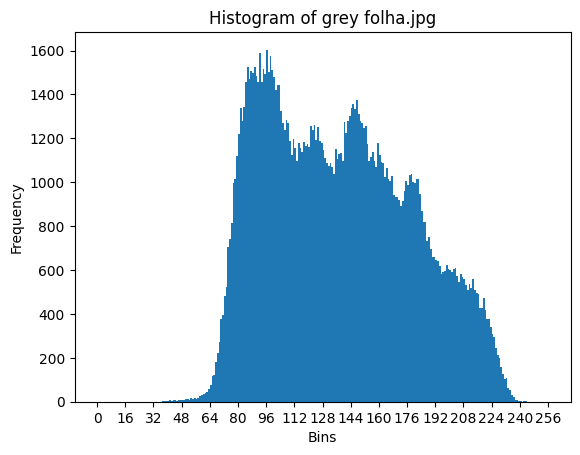

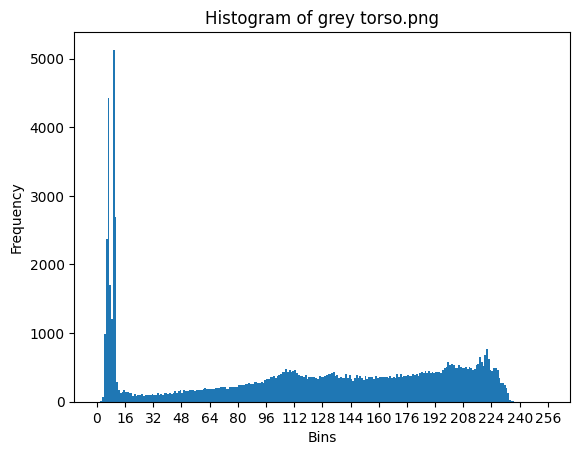

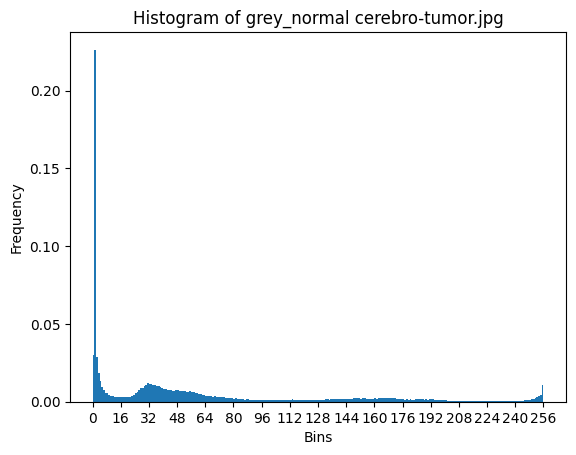

pre-quantization mean: 57.49932098765432
expectancy: 57.99389770723104
median: 35.5
mode: 1.5
first_centered_moment: 3.552713678800501e-15
second_moment: 7995.076512345679
variance: 4631.784341068901
skewness: 427775.1712858715
third_moment: 1428671.2752601411
kurtosis: 83415764.92862894
entropy: 6.421423756047947 bit(s)


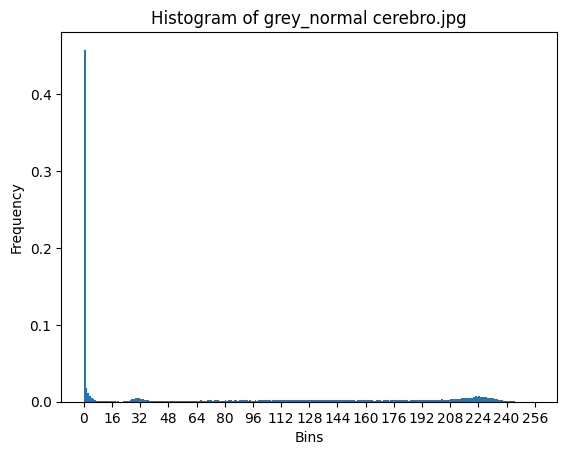

pre-quantization mean: 73.3367702448211
expectancy: 73.8367702448211
median: 5.5
mode: 0.5
first_centered_moment: -5.915081792429167e-14
second_moment: 13237.632203389834
variance: 7785.763563203331
skewness: 468373.18151814805
third_moment: 2595548.459898775
kurtosis: 109381655.21404657
entropy: 5.130767759702917 bit(s)


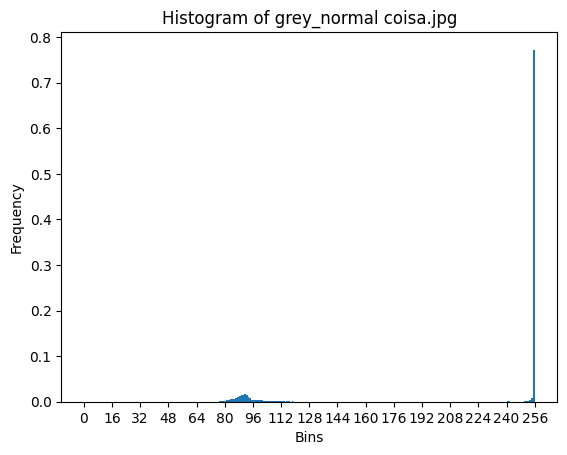

pre-quantization mean: 222.96534814814814
expectancy: 223.07925925925923
median: 255.0
mode: 255.0
first_centered_moment: 3.197442310920451e-14
second_moment: 53804.09162222222
variance: 4039.7357105624146
skewness: -395898.02344093873
third_moment: 13409041.380592592
kurtosis: 56131644.026973784
entropy: 2.0727806269221443 bit(s)


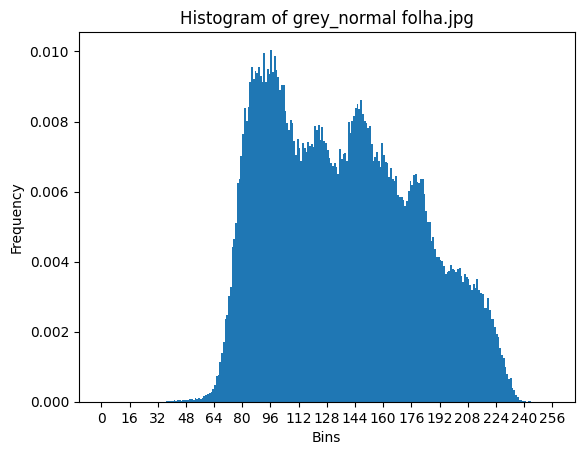

pre-quantization mean: 136.89559523809524
expectancy: 137.39559523809524
median: 134.5
mode: 96.5
first_centered_moment: 1.9941730558525883e-15
second_moment: 20583.848182957387
variance: 1706.2985921268946
skewness: 20963.932061117994
third_moment: 3317969.8268875317
kurtosis: 6111241.1459721485
entropy: 7.276689305914647 bit(s)


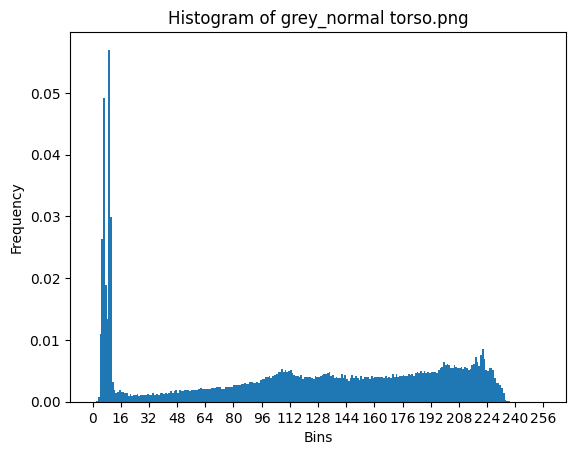

pre-quantization mean: 116.91947777777777
expectancy: 117.41947777777777
median: 125.5
mode: 9.5
first_centered_moment: 6.673481212082777e-15
second_moment: 19535.40895555556
variance: 5748.075193949509
skewness: -89154.70283577814
third_moment: 3554554.789902778
kurtosis: 55293557.04513213
entropy: 7.356484267358706 bit(s)


In [43]:
full_process(images_bw, 8)

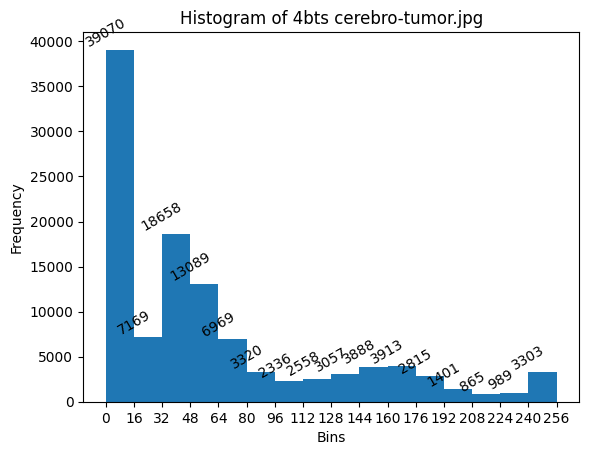

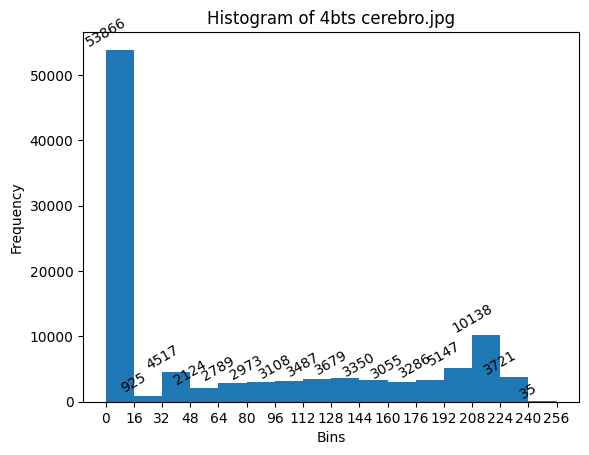

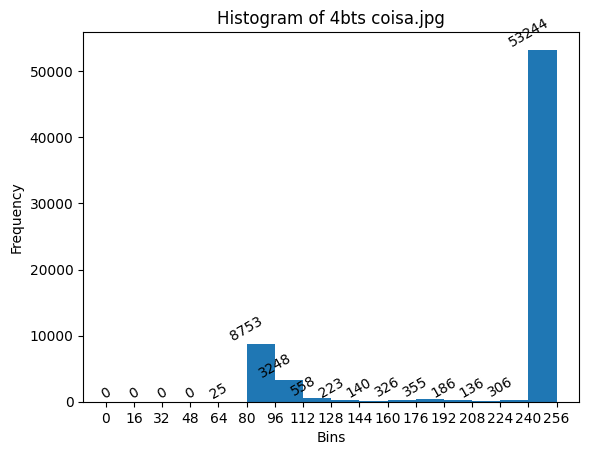

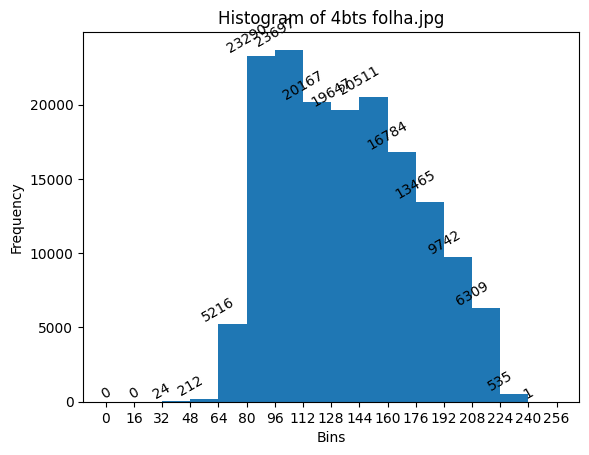

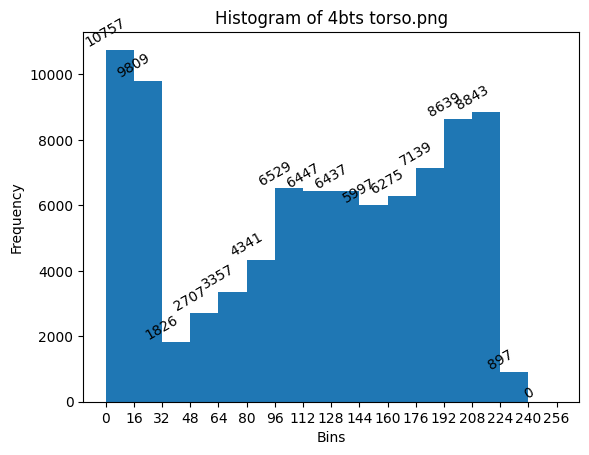

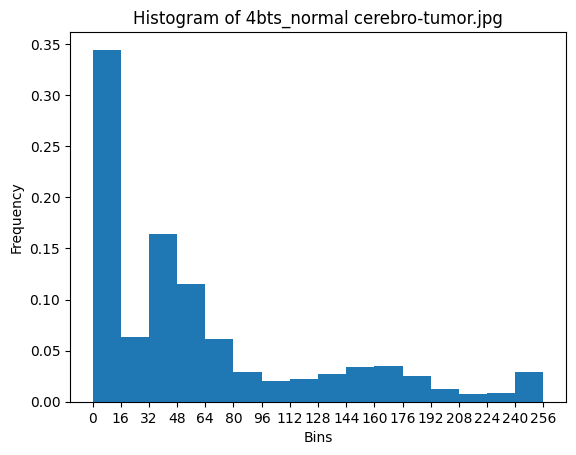

pre-quantization mean: 57.49932098765432
expectancy: 61.98039682539683
median: 40.0
mode: 8.0
first_centered_moment: -2.6645352591003757e-15
second_moment: 8095.160555555556
variance: 4253.590964921895
skewness: 381918.78417988814
third_moment: 1410938.5596560847
kurtosis: 72845265.54932655
entropy: 3.1521866839660593 bit(s)


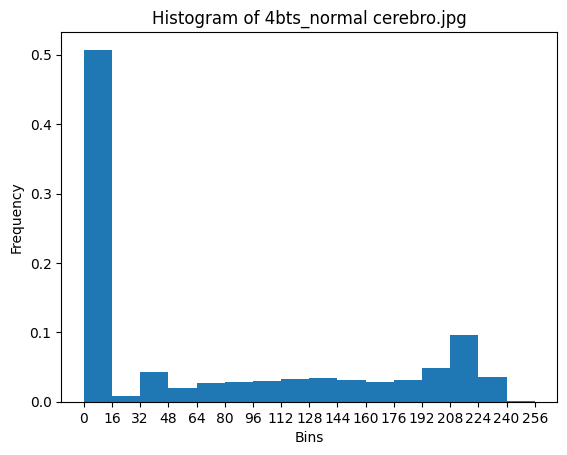

pre-quantization mean: 73.3367702448211
expectancy: 76.98370056497176
median: 8.0
mode: 8.0
first_centered_moment: -3.774758283725532e-15
second_moment: 12839.285602636537
variance: 6912.795449959303
skewness: 392197.87791178457
third_moment: 2444958.746186441
kurtosis: 86532974.28505304
entropy: 2.792349718585198 bit(s)


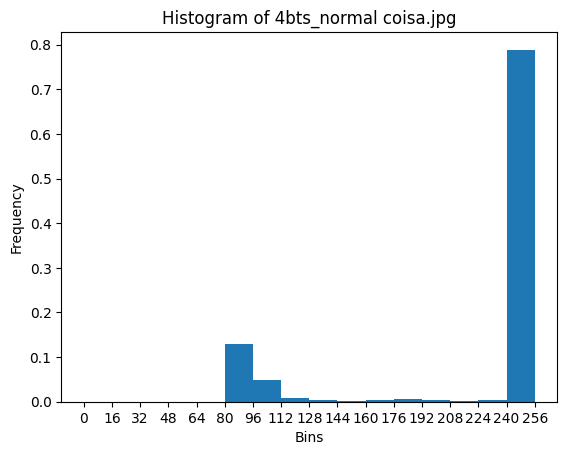

pre-quantization mean: 222.96534814814814
expectancy: 223.15999999999997
median: 255.0
mode: 255.0
first_centered_moment: 2.842170943040401e-14
second_moment: 53808.94714074073
variance: 4008.5615407407413
skewness: -390583.54616888857
third_moment: 13406522.284622222
kurtosis: 55219306.200891875
entropy: 1.123636453452107 bit(s)


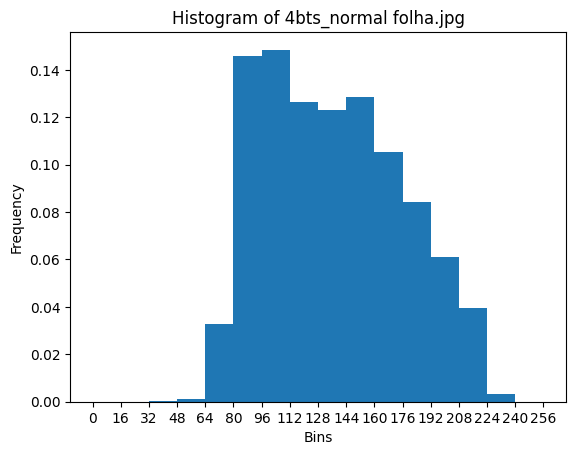

pre-quantization mean: 136.89559523809524
expectancy: 136.87272556390977
median: 136.0
mode: 104.0
first_centered_moment: 7.803870397116164e-15
second_moment: 20266.701560150377
variance: 1532.5585568570157
skewness: 17604.81140314645
third_moment: 3211094.4256578945
kurtosis: 4981394.193858644
entropy: 3.2200000118019116 bit(s)


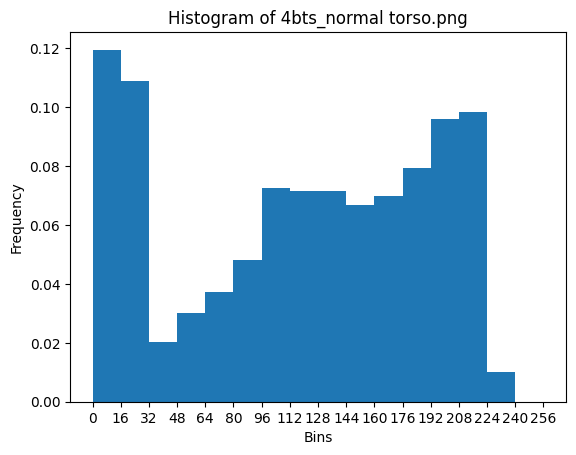

pre-quantization mean: 116.91947777777777
expectancy: 118.03573333333333
median: 120.0
mode: 8.0
first_centered_moment: 7.771561172376096e-15
second_moment: 19056.21333333333
variance: 5123.778989795556
skewness: -77360.93208666617
third_moment: 3381531.2042666664
kurtosis: 44547273.936925724
entropy: 3.726056119410709 bit(s)


In [44]:
full_process(images_bw, 4)

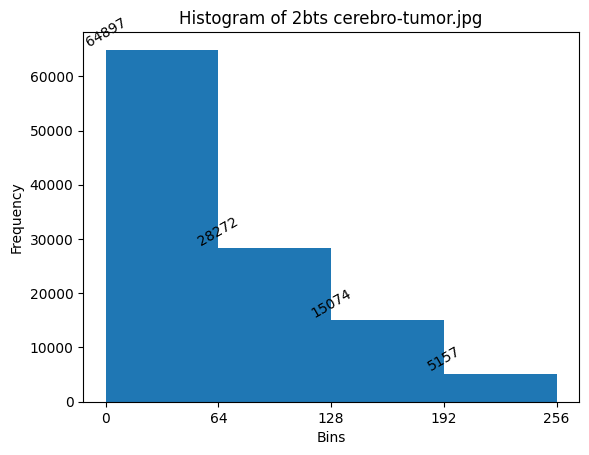

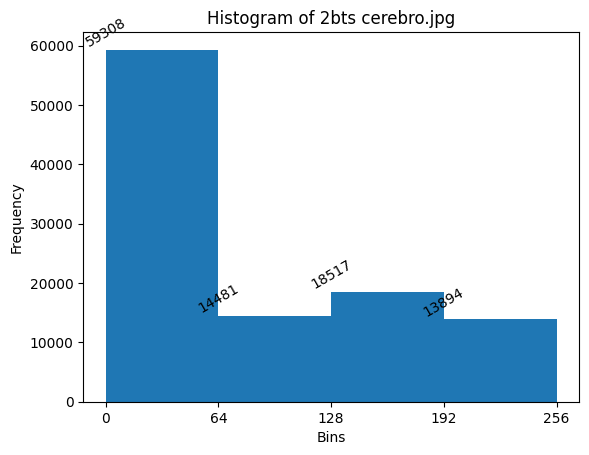

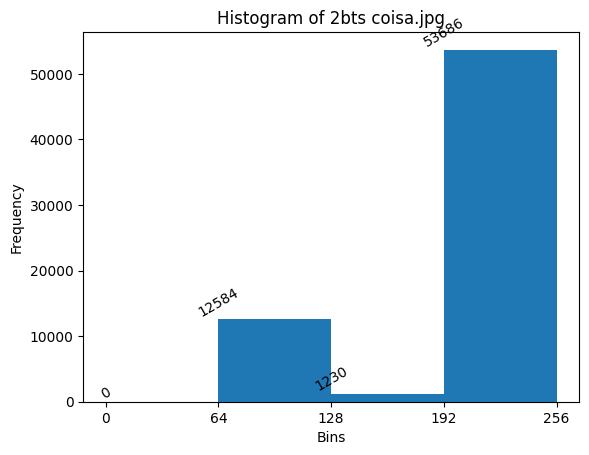

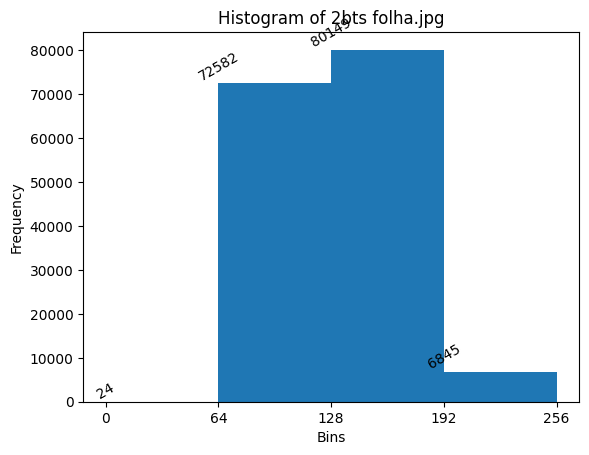

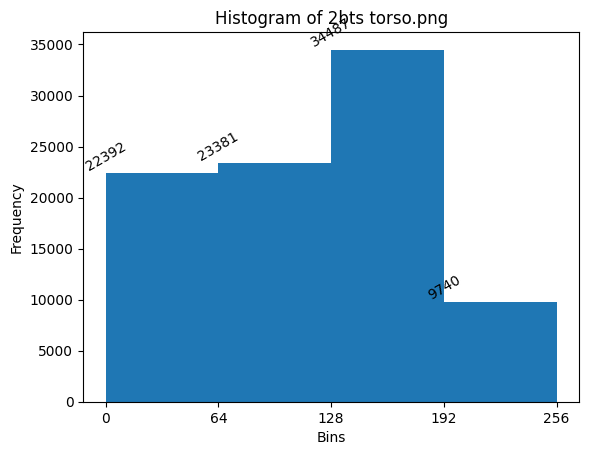

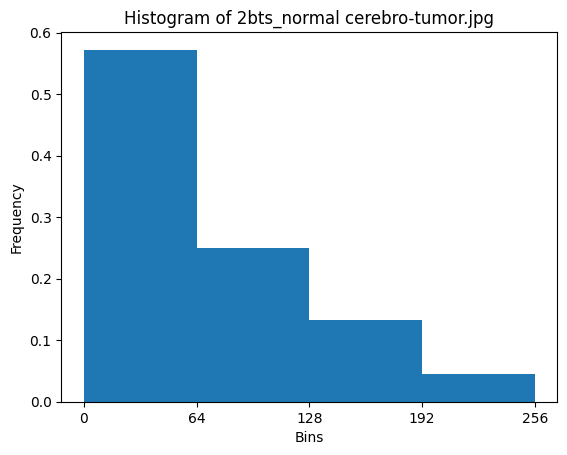

pre-quantization mean: 57.49932098765432
expectancy: 75.11191358024692
median: 32.0
mode: 32.0
first_centered_moment: -3.552713678800501e-15
second_moment: 9243.717857142858
variance: 3601.9182954563767
skewness: 302450.3480492659
third_moment: 1537857.6363580248
kurtosis: 56547341.73164223
entropy: 1.5501738990150173 bit(s)


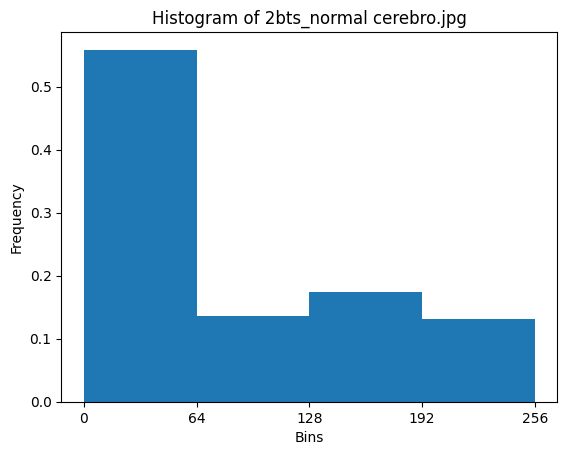

pre-quantization mean: 73.3367702448211
expectancy: 92.21960451977401
median: 32.0
mode: 32.0
first_centered_moment: 0.0
second_moment: 14799.254595103577
variance: 6294.799137320055
skewness: 496645.12151438894
third_moment: 3022434.301412429
kurtosis: 102881053.35435268
entropy: 1.6845819476655763 bit(s)


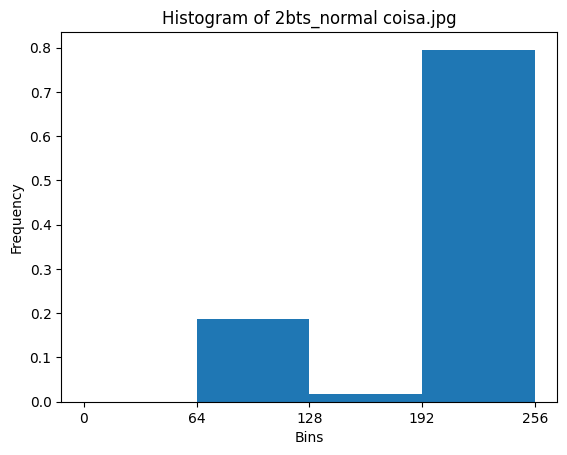

pre-quantization mean: 222.96534814814814
expectancy: 223.62657777777778
median: 255.0
mode: 255.0
first_centered_moment: -7.105427357601002e-15
second_moment: 53902.13768888889
variance: 3893.2914002883954
skewness: -367692.32352686813
third_moment: 13427545.127022222
kurtosis: 50532086.178861
entropy: 0.819801782040205 bit(s)


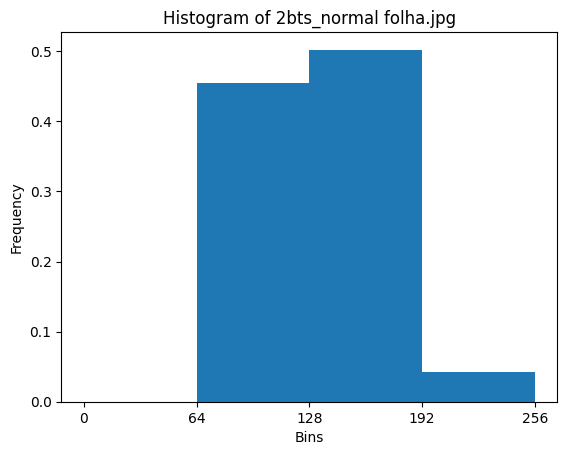

pre-quantization mean: 136.89559523809524
expectancy: 134.94959273182957
median: 160.0
mode: 160.0
first_centered_moment: 6.217248937900877e-15
second_moment: 19836.157976190476
variance: 1624.7653977038067
skewness: 55062.56110473101
third_moment: 3170466.8587656636
kurtosis: 10169616.283421295
entropy: 1.2127655432678999 bit(s)


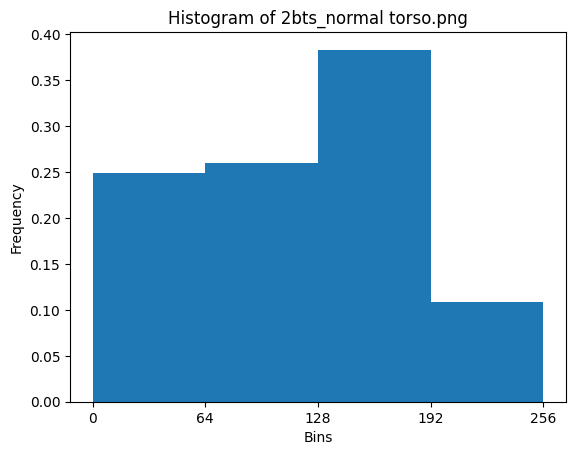

pre-quantization mean: 116.91947777777777
expectancy: 121.80822222222221
median: 96.0
mode: 160.0
first_centered_moment: 1.2434497875801753e-14
second_moment: 19495.771155555558
variance: 4658.528154617284
skewness: 92372.90900718595
third_moment: 3602012.199688889
kurtosis: 51174129.87127382
entropy: 1.8819634945041481 bit(s)


In [45]:
full_process(images_bw, 2)

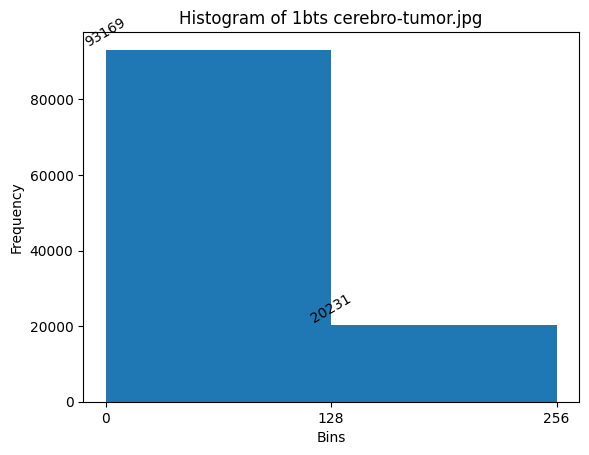

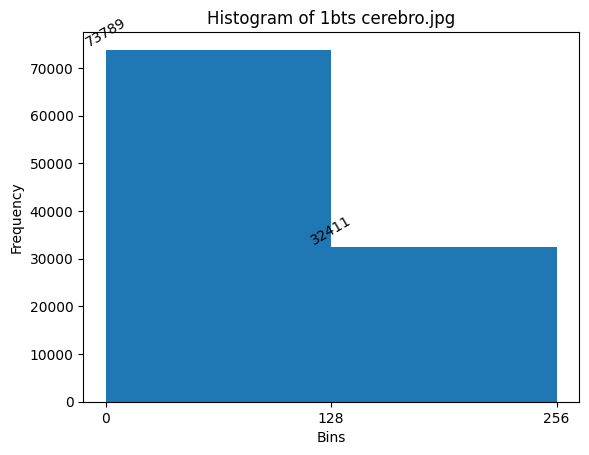

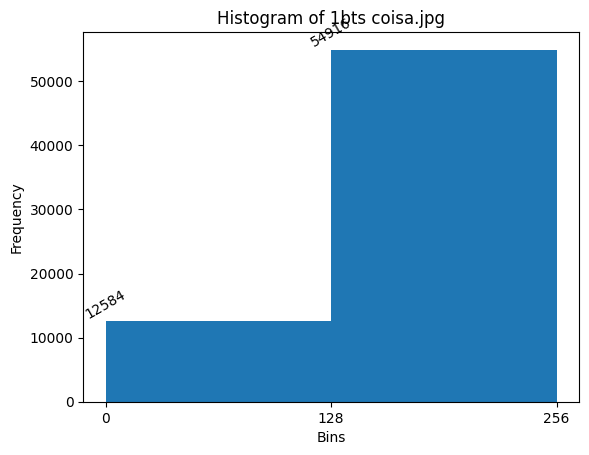

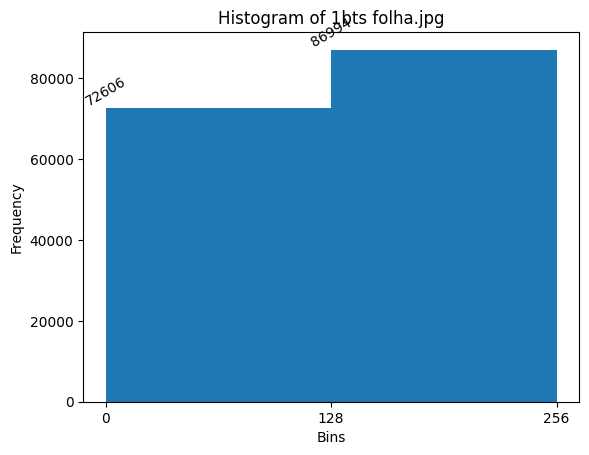

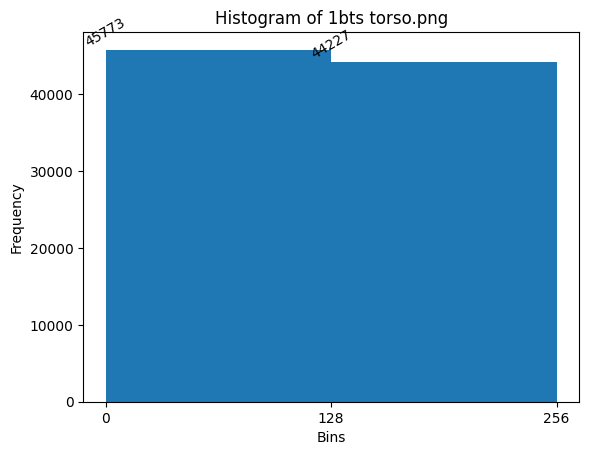

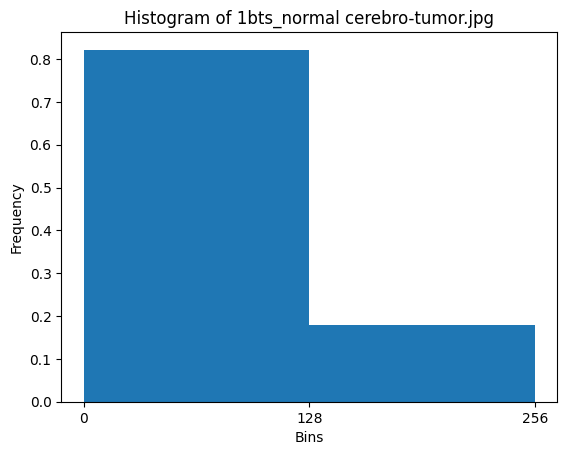

pre-quantization mean: 57.49932098765432
expectancy: 98.07514109347443
median: 64.0
mode: 64.0
first_centered_moment: 0.0
second_moment: 14965.970008818342
variance: 5347.236708313426
skewness: 656906.5206958929
third_moment: 3173558.1301675485
kurtosis: 109293721.11177829
entropy: 0.6765728512417816 bit(s)


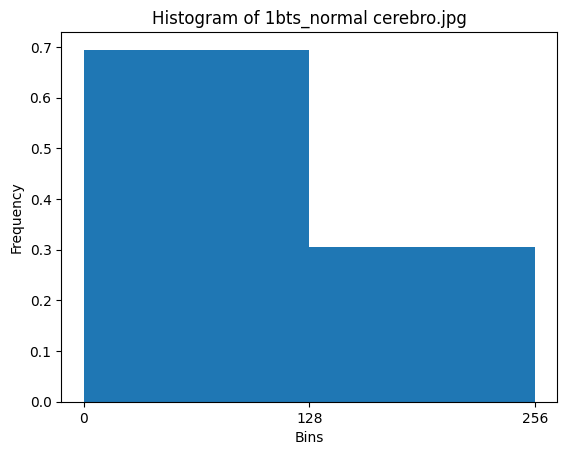

pre-quantization mean: 73.3367702448211
expectancy: 122.29096986817325
median: 64.0
mode: 64.0
first_centered_moment: 7.105427357601002e-15
second_moment: 22690.819387947267
variance: 7735.7380766488095
skewness: 575678.6223718901
third_moment: 5242582.756506591
kurtosis: 102682530.00268257
entropy: 0.8875409027810224 bit(s)


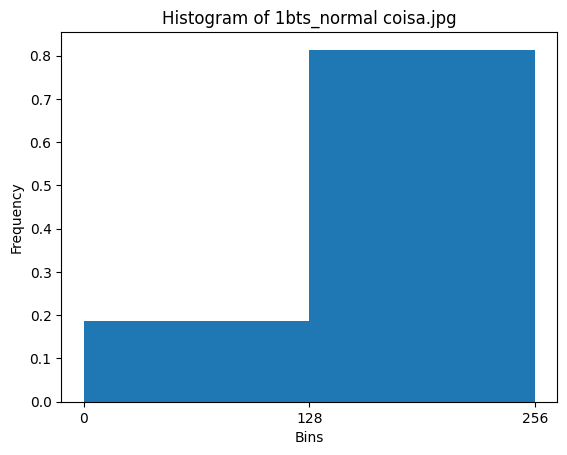

pre-quantization mean: 222.96534814814814
expectancy: 219.39194074074075
median: 255.0
mode: 255.0
first_centered_moment: -1.0658141036401503e-14
second_moment: 53666.0290962963
variance: 5533.2054343076
skewness: -662788.8239557911
third_moment: 13538986.80882963
kurtosis: 110007780.31422211
entropy: 0.6939424831734017 bit(s)


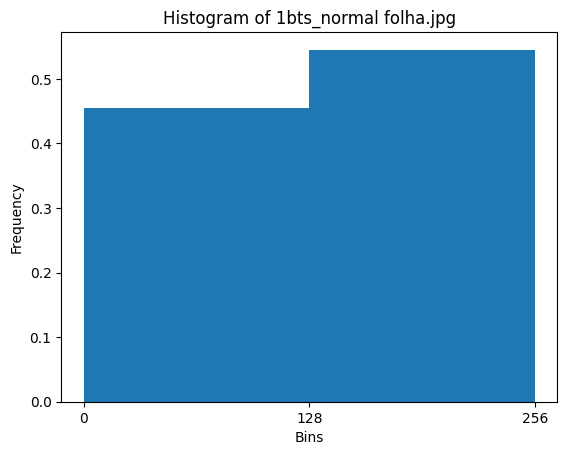

pre-quantization mean: 136.89559523809524
expectancy: 168.10936090225564
median: 255.0
mode: 255.0
first_centered_moment: -7.105427357601002e-15
second_moment: 37306.88612781955
variance: 9046.128904854711
skewness: -155762.77702044178
third_moment: 9157351.904849624
kurtosis: 84514484.08826101
entropy: 0.9941295768639902 bit(s)


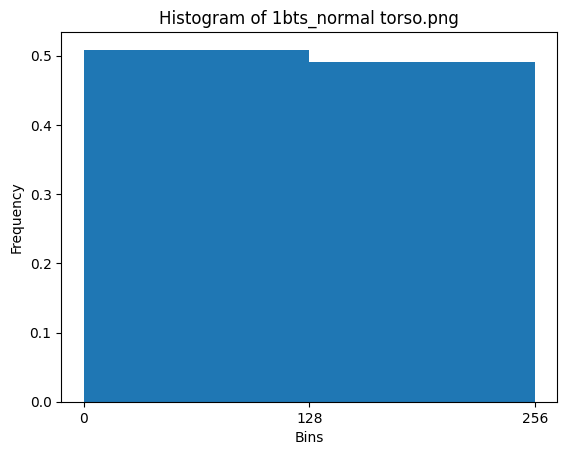

pre-quantization mean: 116.91947777777777
expectancy: 157.85952222222224
median: 64.0
mode: 64.0
first_centered_moment: -1.4210854715202004e-14
second_moment: 34037.18758888889
variance: 9117.55883266062
skewness: 29914.30530512199
third_moment: 8281595.438188889
kurtosis: 83228026.57320906
entropy: 0.9997871371542599 bit(s)


In [46]:
full_process(images_bw, 1)